In [1]:
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence
!pip install minepy
!pip install boruta
!pip install extra_keras_metrics

  Created wheel for epigenomic-dataset: filename=epigenomic_dataset-1.2.11-py3-none-any.whl size=16125 sha256=7a7a831a521c9976e8e039ecfcaa6394821c882817e43aeb221ac27f8b753686
  Stored in directory: /root/.cache/pip/wheels/55/ae/00/711945f7eb139c3e7b5afd32628e468070b86698175d938b43
  Created wheel for crr-labels: filename=crr_labels-1.1.1-py3-none-any.whl size=13910 sha256=a950c0755536b7f86ae1075a84fe0f203a00e5dc97e1d6915f808a45f459ea7e
  Stored in directory: /root/.cache/pip/wheels/11/35/18/9f4c037100da0b7c44bbe85ed0d0e0520d71855f8d92c399c1
  Created wheel for encodeproject: filename=encodeproject-1.0.27-py3-none-any.whl size=9621 sha256=99c100c906f296fb4c807c0d91825f255013b93b648f646fb2cb787c309e3586
  Stored in directory: /root/.cache/pip/wheels/74/03/63/a272266e6c9c3d5ce2ccf1088508c952e91b0101650730ce44
  Created wheel for notipy-me: filename=notipy_me-1.3.23-py3-none-any.whl size=11705 sha256=55795ee54c9075a877059bc3d00b2dbc36d10ad34c44545c435021c4e7f483bf
  Stored in directory: /r

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer, Layer
from tensorflow.keras.layers import Conv1D, Reshape, Flatten, MaxPool1D, AveragePooling1D
from tensorflow.keras.layers import Dropout, Concatenate, Input, ReLU, GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalMaxPool1D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from extra_keras_metrics import get_standard_binary_metrics

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr
from scipy.stats import entropy
from minepy import MINE

from scipy.stats import wilcoxon
import scipy.stats as st

from typing import Dict
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import recall_score, precision_score, f1_score

from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence

from ucsc_genomes_downloader import Genome
from epigenomic_dataset import load_epigenomes

**Data retrieval**

In [3]:
# Window_size is the size of the regions considered for the classification.
window_size = 256

In [4]:
# The value assigned to the variable assembly simply indicate the uman genome. 
assembly="hg38"

# The cell_line indicate the type of the human cell for which the DNA is being considered.
cell_line="GM12878"

In [5]:
# Import the epigenomes and labels (originaly obtained from ENCODE and FANDOM respectively) for enanchers.

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "enhancers",
    window_size = window_size,
    binarize = True
)

In [6]:
# Trasform the boolean labels into integer (false->0,true->1).
enhancers_labels['GM12878']=enhancers_labels['GM12878'].astype(int)

In [7]:
# Examples of enhancers epigenomes (features of the BED format more the level of interanction with the given genes).
enhancers_epigenomes.head()

chrom                              SMAD5  CEBPZ  MEF2C  ...  E2F4  E4F1  CHD4
chrom chromStart chromEnd  strand                       ...                  
chr10 100006381  100006637 .        0.80   1.41   1.31  ...  0.89  0.83  0.93
      100008146  100008402 .        0.69   1.37   0.33  ...  0.43  0.74  0.99
      100014418  100014674 .        1.21   1.66   3.00  ...  0.52  0.59  1.56
      100020216  100020472 .        1.16   1.51   0.87  ...  0.72  1.33  1.57
      100043528  100043784 .        0.49   1.13   0.17  ...  1.22  2.02  1.12

[5 rows x 152 columns]

In [8]:
# Examples of enanchers labels from fantom.
enhancers_labels.head()

GM12878
chrom chromStart chromEnd  strand         
chr10 100006381  100006637 .             0
      100008146  100008402 .             0
      100014418  100014674 .             0
      100020216  100020472 .             0
      100043528  100043784 .             0

In [9]:
# Create BED format dataset.
bed_X = enhancers_epigenomes.reset_index()
bed = bed_X[bed_X.columns[:4]]

bed

chrom,chrom,chromStart,chromEnd,strand
0,chr10,100006381,100006637,.
1,chr10,100008146,100008402,.
2,chr10,100014418,100014674,.
3,chr10,100020216,100020472,.
4,chr10,100043528,100043784,.
...,...,...,...,...
63280,chrY,7520247,7520503,.
63281,chrY,7724272,7724528,.
63282,chrY,7770029,7770285,.
63283,chrY,7796295,7796551,.


In [10]:
# create three dictionaries, one for the epigenomes, one for the labels, and one for the bed format.

epigenomes = {
    "enhancers": enhancers_epigenomes
}

bed = {
    "enhancers": bed
}

labels = {
    "enhancers": enhancers_labels
}

In [11]:
# Retrive from the  UCSC Genome Browser the nitrogen basis sequences of the human genome. 

genome = Genome(assembly)

In [12]:
# Transform the genome in a dataframe where the nitrogen basis sequences are represented throgh one hot encoding.

# Return data in BED format.
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# One hot encode the data.
def one_hot_encode(genome:Genome, data:pd.DataFrame, nucleotides:str="actg")->np.ndarray:
    return np.array(BedSequence(
        genome,
        bed=to_bed(data),
        nucleotides=nucleotides,
        batch_size=1
    ))

# Flatten the one hot encode representation.
def flat_one_hot_encode(genome:Genome, data:pd.DataFrame, window_size:int, nucleotides:str="actg")->np.ndarray:
    return one_hot_encode(genome, data, nucleotides).reshape(-1, window_size*4).astype(int)

# Create a dataframe from the data.
def to_dataframe(x:np.ndarray, window_size:int, nucleotides:str="actg")->pd.DataFrame:
    return pd.DataFrame(
        x,
        columns = [
            f"{i}{nucleotide}"
            for i in range(window_size)
            for nucleotide in nucleotides
        ]
    )

# The dataset of the genome sequences will be identifyed by the dictionary sequences.
sequences = {
    region: to_dataframe(
        flat_one_hot_encode(genome, data, window_size),
        window_size
    )
    for region, data in epigenomes.items()
}            

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
# Examples of enhancers one hot encoded sequences. 
sequences["enhancers"][:5]

,0a,0c,0t,0g,1a,1c,1t,1g,2a,2c,2t,2g,3a,3c,3t,3g,4a,4c,4t,4g,5a,5c,5t,5g,6a,6c,6t,6g,7a,7c,7t,7g,8a,8c,8t,8g,9a,9c,9t,9g,...,246a,246c,246t,246g,247a,247c,247t,247g,248a,248c,248t,248g,249a,249c,249t,249g,250a,250c,250t,250g,251a,251c,251t,251g,252a,252c,252t,252g,253a,253c,253t,253g,254a,254c,254t,254g,255a,255c,255t,255g
0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0


**Data pre-pocessing**

In [14]:
# Check the presence of missing values.

for region, data in epigenomes.items():
  print("{} data:".format(region))
  print("Total number of NaN values: {0} over {1}".format(data.isna().values.sum(),data.values.size))
  print("Max number of NaN values per feature: {0} over {1}".format(data.isna().values.sum(axis=0).max(),data.shape[0]))
  print("Max number of NaN values per sample: {0} over {1}".format(data.isna().values.sum(axis=1).max(),data.shape[1]))
  print("\n")

enhancers data:
Total number of NaN values: 62 over 9619320
Max number of NaN values per feature: 56 over 63285
Max number of NaN values per sample: 4 over 152




In [15]:
# Drop the samples with more than 30 NaN values.
for region, data in epigenomes.items():
  index=data.isna().values.sum(axis=1)
  index=[i for i in range(0,len(index)) if index[i]>30]
  for i in reversed(index):
    epigenomes[region]=data.drop(data.index[i])
    labels[region]=labels[region].drop(labels[region].index[i])
    sequences[region]=sequences[region].drop(sequences[region].index[i])

In [16]:
# Check the presence of missing values.

for region, data in epigenomes.items():
  print("{} data:".format(region))
  print("Total number of NaN values: {0} over {1}".format(data.isna().values.sum(),data.values.size))
  print("Max number of NaN values per features: {0} over {1}".format(data.isna().values.sum(axis=0).max(),data.shape[0]))
  print("Max number of NaN values per sample: {0} over {1}".format(data.isna().values.sum(axis=1).max(),data.shape[1]))
  print("\n")

enhancers data:
Total number of NaN values: 62 over 9619320
Max number of NaN values per features: 56 over 63285
Max number of NaN values per sample: 4 over 152




In [17]:
# Impute the missing data with the k-NN imputer (k=5).
# In other words, assign to each missing feature value for a given sample, the same feature value of the most "similar" sample.

imputer = KNNImputer()

for region, data in epigenomes.items():
  # Tranform the result of the imputer in a dataframe with the same columns and rows of the one in input.
  epigenomes[region]=pd.DataFrame(imputer.fit_transform(data),columns=data.columns,index=data.index)

In [18]:
# There should not be missing values anymore.

for region, data in epigenomes.items():
  print("{} data:".format(region))
  if (data.isna().values.any()):
    print("missing values are still presents")
  else:
    print("there are no more missing values")
  print("\n")

enhancers data:
there are no more missing values




In [19]:
# normalization of the data throgh robust scaler, a version of the scaler konwn as z-score.

scaler=RobustScaler()

for region, data in epigenomes.items():
  # Tranform the result of the scaler in a dataframe with the same columns and rows of the one in input.
  epigenomes[region]=pd.DataFrame(scaler.fit_transform(data),columns=data.columns,index=data.index)

In [20]:
# Print the two ratios between active and inactive samples.

for region, label in labels.items():
  active_count=len(label[(label['GM12878']==1)])
  inactive_count=len(label[(label['GM12878']==0)])

  active_ratio=active_count/active_count
  inactive_ratio=inactive_count/active_count
  print('ratio between active/inactive for {0} is: {1}/{2}'.format(region, active_ratio, inactive_ratio))

ratio between active/inactive for enhancers is: 1.0/35.26647564469914


**Correlation**

In [21]:
# p-values and correlations thresholds.

p_value_threshold = 0.01
correlation_threshold = 0.05

In [22]:
# Create the sets of features uncorrelated whit the output for both the enhanchers and the promoters.
# Initialy this sets will be empty, features will be added after the tests.

uncorrelated = {}

for region, _ in epigenomes.items():
  uncorrelated[region] = set()

In [23]:
# Compute the Spearman correlation between the features and their outputs to find out if they are not correlated according to a monotonic function.
# Add the uncorrelated features to the set of the region in the dictionary uncurrelated.

for region, data in epigenomes.items():
  for column in data.columns:
    correlation, p_value = spearmanr(data[column].values.ravel(), labels[region].values.ravel())
    if p_value > p_value_threshold and correlation < correlation_threshold:
      print("For the {0} feature {1} dosen't seem to be correlated to the output, correlation: {2}".format(region,column,correlation))
      uncorrelated[region].add(column)

For the enhancers feature NFYA dosen't seem to be correlated to the output, correlation: 0.0035538192219031236


In [24]:
# Compute the Maximal information coefficient to confirm that the feature previusly identified as uncurrelated to the output.
# This test check both linear and non-linear correlation.

for region, data in epigenomes.items():
  for column in uncorrelated[region]:
    mine = MINE()
    mine.compute_score(data[column].values.ravel(), labels[region].values.ravel())
    computed_score=mine.mic()
    if computed_score < correlation_threshold:
      print("For the {0} feature {1} dosen't seem to be correlated to the output, correlation: {2}".format(region,column,computed_score))
    else:
        uncorrelated[region].remove(column)
        print("For the {0} feature {1} seem to be correlated to the output, correlation: {2}".format(region,column,computed_score))
        print("Removing the feature from the set of features uncorrelated with the output")


For the enhancers feature NFYA dosen't seem to be correlated to the output, correlation: 0.009955576156008636


In [25]:
# Remove features which are not correlated to the output.

for region, data in epigenomes.items():
  columns_to_drop=[]
  for column in uncorrelated[region]:
    columns_to_drop.append(column) 
  epigenomes[region]=data.drop(columns=columns_to_drop)    


In [26]:
# Print number of columns in the two datasets.
for region, data in epigenomes.items():
  print('Number of features in {0}: {1}'.format(region,len(data.columns)))

Number of features in enhancers: 151


In [27]:
# redefine p-values and correlations thresholds.

p_value_threshold = 0.01
correlation_threshold = 0.95

In [28]:
# Create the sets of features uncorrelated with each others for both the enhanchers and the promoters.
# Initialy this sets will be empty, features will be added after the tests.

extremely_correlated = {}

for region, data in epigenomes.items():
  extremely_correlated[region]= set()

In [29]:
# Correlation scores will be stored in a dictionary of array of tuples (correlation score,first feature,second feature).

correlation_scores={}

for region,data in epigenomes.items():
  correlation_scores[region]= []

In [30]:
# Compute the correlation scores.

for region, data in epigenomes.items():
  columns_names=data.columns
  for i in range(0,data.shape[1]):
    for j in range(i+1,data.shape[1]):
       correlation, p_value = spearmanr(data[columns_names[i]].values.ravel(), data[columns_names[j]].values.ravel())
       # Correlation absolute value.
       correlation = np.abs(correlation)
       correlation_scores[region].append((correlation,columns_names[i],columns_names[j]))
       if p_value < p_value_threshold and correlation > correlation_threshold:
                print("For {0} feature {1} and feature {2} seems to be highly correlated, correlation: {3} ".format(region, columns_names[i], columns_names[j], correlation))
                # If the two feature are highly correlated, add to the list of highly correlated features the one of the two with the lower entropy.
                if entropy(data[columns_names[i]]) > entropy(data[columns_names[i]]):
                    extremely_correlated[region].add(columns_names[j])
                else:
                    extremely_correlated[region].add(columns_names[i])

**Feature selection with Boruta.**

In [31]:
# Boruta use a random forest classifier inside its procedure.
# This classifier is here defined as random_forest_classifier.
random_forest_classifier=RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# The function recive a dataset and its labels and return the classifier filtered.
def boruta_feature_selection(X:pd.DataFrame,y:pd.DataFrame)->BorutaPy:
  
  # alpha is the p-value that will be used to reject of accept the features.
  boruta_feature_selector=BorutaPy(random_forest_classifier,n_estimators='auto',verbose=2,alpha=0.05,max_iter=10,random_state=1)

  boruta_feature_selector.fit(X.values, y.values.ravel())
  
  return boruta_feature_selector.transform(X.values)

In [32]:
filtered_epigenomes={}

for region, data in epigenomes.items():
  filtered_epigenomes[region]=boruta_feature_selection(data,labels[region])

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	98
Tentative: 	53
Rejected: 	0
Iteration: 	9 / 10
Confirmed: 	98
Tentative: 	44
Rejected: 	9


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	98
Tentative: 	19
Rejected: 	9


**Holdouts**

In [33]:
# Create a statified holdouts generator that split the data in 5 folds, using one of them as test set, and repeating the split 10 times.
# The folds created will mantain the original percentage of samples for each class.
number_of_splits = 8

holdouts_generator = StratifiedShuffleSplit(n_splits=number_of_splits,test_size=0.2)

**Models evaluation**

In [34]:
# Metrics that will be used to evaluate the results.
metrics=("AUPRC", "AUROC", "accuracy", "f1_score", "precision", "recall")

# Definition of the class weights to reduce the impact of the imbalance in the dataset.
class_weights={0: 1, 1: 9}

In [35]:
# Evaluate the nerual network passed.
# Returns two dictionaries with the values for the metrics chosen for test and train set.
def evaluate_nn_model(train_sequence:MixedSequence, test_sequence:MixedSequence, model:Model, model_name:str, holdout_number:int, use_feature_selection:bool,):

    train_evaluation={}
    test_evaluation={}

    for metric,value in zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)):
      if metric in metrics :
        train_evaluation[metric]=value

    for metric,value in zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)):
      if metric in metrics :
        test_evaluation[metric]=value

    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"

    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["holdout_number"] = holdout_number

    return [train_evaluation,test_evaluation] 

In [36]:
# Compute the evaluations of the metrics required for the random forest and store them in a dictionary.
def metric_forest_evaluation(y_true:np.ndarray, y_pred:np.ndarray):
    metrics={}
    metrics['accuracy']=accuracy_score(y_true,y_pred)
    metrics['AUROC']=roc_auc_score(y_true,y_pred)
    metrics['f1_score']=f1_score(y_true,y_pred)
    metrics['AUPRC']=average_precision_score(y_true,y_pred)
    metrics['recall']=recall_score(y_true,y_pred)
    metrics['precision']=precision_score(y_true,y_pred)

    return metrics  

**Models**

In [37]:
# Definition of the random forest classifier.

def train_random_forest(
  X_train:np.ndarray, X_test:np.ndarray, y_train:np.ndarray, y_test:np.ndarray, holdout_number:int, use_feature_selection:bool=True) -> Dict[str, float]:

  random_forest=RandomForestClassifier(n_estimators=150,class_weight="balanced",max_depth=8,min_samples_leaf=50,max_samples=0.35,n_jobs=-1,verbose=False)
  random_forest.fit(X_train,y_train)

  y_train_pred = random_forest.predict(X_train)
  y_test_pred = random_forest.predict(X_test)

  # Create a disctionary with the evaluation 
  common_informations = {
      "model_name": "Random Forest",
      "holdout_number": holdout_number,
  }  

  # Returns dictionaries of the prediction evaluation for the train and test set.
  return [
          {
            **metric_forest_evaluation(y_train,y_train_pred),
            "run_type": "train",
            **common_informations
          },
          {
            **metric_forest_evaluation(y_train,y_train_pred),
            "run_type": "test",
            **common_informations
          }
  ]

In [38]:
# Build the sequences to give in input to the neural networks. 

def build_ffnn_sequence( X:np.ndarray, y:np.ndarray, batch_size=1024 ) -> MixedSequence:

    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


def build_cnn_sequence( bed: pd.DataFrame, y: np.ndarray, genome: Genome, batch_size: int ) -> MixedSequence:

    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )   


def build_mmnn_sequence( X: np.ndarray, bed: pd.DataFrame, y: np.ndarray, genome: Genome, batch_size: int) -> MixedSequence: 

    return MixedSequence(
        x={
            "sequence_data": BedSequence(genome, bed, batch_size=batch_size),
            "epigenomic_data": VectorSequence(X,batch_size=batch_size)
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )       

In [39]:
# Definition and training of the multilayer feedforward neural network classifier.

def train_ffnn(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool=True
) -> Dict[str, float]:
    
    # build the sequences for the training and the evaluation.
    train_sequence=build_ffnn_sequence(X_train,y_train)
    test_sequence=build_ffnn_sequence(X_test,y_test)

    input_layer = Input(shape=(X_train.shape[1]), name="epigenomic_data")
    hidden_layer = Dense(32, activation="relu")(input_layer)
    hidden_layer = Dropout(0.3)(hidden_layer)
    hidden_layer = Dense(16, activation="relu")(hidden_layer)
    hidden_layer = Dropout(0.3)(hidden_layer)
    hidden_layer = Dense(16, activation="relu")(hidden_layer)

    output_layer=Dense(1, activation="sigmoid")(hidden_layer)

    ffnn=Model(inputs=input_layer,outputs=output_layer)

    ffnn.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=get_standard_binary_metrics()
    )

    ffnn.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=150,
        batch_size=1024,
        class_weight=class_weights,
        verbose=False,
        callbacks=[
            EarlyStopping("loss", mode='min', patience=3),
        ]
    )

    # Return first and last layer and the evaluation of the model.
    return input_layer, hidden_layer, evaluate_nn_model( train_sequence, test_sequence, ffnn, "FFNN", holdout_number, use_feature_selection )

In [40]:
# Definition and training of the convolutional neural network classifier.

def train_cnn(
    bed_train:pd.DataFrame, bed_test:pd.DataFrame, y_train:np.ndarray, y_test:np.ndarray, genome:Genome, holdout_number:int, batch_size:int=1024, window_size:int=256,  use_feature_selection:bool=True) -> Dict[str, float]:

    train_sequence = build_cnn_sequence(bed_train, y_train, genome, batch_size=batch_size)
    test_sequence = build_cnn_sequence(bed_test, y_test, genome, batch_size=batch_size)
    

    input_layer = Input(shape=(window_size, 4), name="sequence_data")
    hidden_layer = Conv1D(32, kernel_size=6, activity_regularizer=regularizers.l2(0.0005), activation="relu")(input_layer)
    hidden_layer = Dropout(0.2)(hidden_layer)
    hidden_layer = AveragePooling1D(pool_size=4, strides=2, padding='same')(hidden_layer)
    hidden_layer = Conv1D(32, kernel_size=4, activity_regularizer=regularizers.l2(0.0005), activation="relu")(hidden_layer)
    hidden_layer = Conv1D(32, kernel_size=4, activity_regularizer=regularizers.l2(0.0005), activation="relu")(hidden_layer)
    hidden_layer = GlobalAveragePooling1D()(hidden_layer)
    hidden_layer = Dense(64, activation="relu")(hidden_layer)
    hidden_layer = Dropout(0.3)(hidden_layer)
    hidden_layer = Dense(32, activation="relu")(hidden_layer)
    hidden_layer = Dropout(0.2)(hidden_layer)
    hidden_layer = Dense(16, activation="relu")(hidden_layer)

    output_layer=Dense(1, activation="sigmoid")(hidden_layer)

    cnn=Model(inputs=input_layer,outputs=output_layer)

    cnn.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=get_standard_binary_metrics()
    )

    cnn.fit(
          train_sequence,
          validation_data=test_sequence,
          epochs=150,
          batch_size=batch_size,
          class_weight=class_weights,
          verbose=False,
          callbacks=[ 
                    EarlyStopping("loss", mode='min', patience=3),
          ]
    )

    # Return first and last layer and the evaluation of the model.
    return input_layer, hidden_layer, evaluate_nn_model( train_sequence, test_sequence, cnn, "CNN", holdout_number, use_feature_selection )
    

In [41]:
# Definition and training of the multimodal neural network classifier.
# It is build starting from the two previous networks.

def train_mmnn(
    X_train:np.ndarray, X_test:np.ndarray, bed_train:pd.DataFrame, bed_test:pd.DataFrame, y_train:np.ndarray, y_test:np.ndarray, genome:Genome,
    holdout_number:int, batch_size:int=1024, use_feature_selection:bool=True,
    hidden_cnn:Layer=None, hidden_ffnn:Layer=None, input_ffnn:Layer=None, input_cnn:Layer=None
) -> Dict[str, float]:

    train_sequence = build_mmnn_sequence(X_train, bed_train, y_train, genome, batch_size=batch_size)
    test_sequence = build_mmnn_sequence(X_test, bed_test, y_test, genome, batch_size=batch_size)

    # Concatenate togheter the two previous NN.
    concatenation_layer = Concatenate()([ hidden_ffnn,hidden_cnn ])

    last_hidden_mmnn = Dense(32, activation="relu")(concatenation_layer)
    output_layer = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn=Model(inputs=[input_ffnn,input_cnn],outputs=output_layer)

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_standard_binary_metrics()
    )

    mmnn.fit(
          train_sequence,
          validation_data=test_sequence,
          epochs=150,
          batch_size=batch_size,
          class_weight=class_weights,
          verbose=False,
          callbacks=[ 
                    EarlyStopping("loss", mode='min', patience=3),
          ]
    )

    return evaluate_nn_model( train_sequence, test_sequence, mmnn, "MMNN", holdout_number, use_feature_selection )


In [51]:
# Create a list to store all the computed performance.
all_performance = {'enhancers':[]}

for region, data in epigenomes.items(): 
  # Start the main loop, iterating through the holdouts.
  for holdout_number, (train_indices, test_indices) in enumerate(holdouts_generator.split(data, labels[region])):
        X_train, X_test = data.iloc[train_indices].values, data.iloc[test_indices].values
        bed_train, bed_test = bed[region].iloc[train_indices], bed[region].iloc[test_indices]
        y_train, y_test = labels[region].iloc[train_indices].values, labels[region].iloc[test_indices].values
      
        # Print the number of the current holdouts considered.
        print("holdouts: {}".format(holdout_number))

        # Train the models defined and compute the results.

        # Random forest training.
        print("forest training")
        performance = train_random_forest(
                      X_train, X_test, y_train.ravel(), y_test.ravel(), holdout_number
                      )
        all_performance[region] += performance

        # Feedforward NN training.
        print("ffnn training")
        input_ffnn, ffnn_trained, performance = train_ffnn(
              X_train, X_test, y_train, y_test, holdout_number
        )
        all_performance[region]+= performance

        # Convolutional NN training.
        print("cnn training")
        input_cnn, cnn_trained, performance = train_cnn(
              bed_train, bed_test, y_train.flatten(), y_test.flatten(), genome, holdout_number, 1024, 256
        )
        all_performance[region]+= performance 

        # Multimodal NN training.
        print("mmnn training")
        performance = train_mmnn(
                      X_train, X_test, bed_train, bed_test, y_train.flatten(), y_test.flatten(), genome, holdout_number, 1024,
                      hidden_cnn=cnn_trained, hidden_ffnn=ffnn_trained, input_ffnn=input_ffnn, input_cnn=input_cnn
                      )
        all_performance[region]+= performance
    
  # We convert the computed performance list into a DataFrame
  all_performance[region] = pd.DataFrame(all_performance[region])

holdouts: 0
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 1
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 2
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 3
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 4
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 5
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 6
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training
holdouts: 7
forest training
ffnn training


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric BalancedAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric Specificity implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))
/usr/local/lib/python3.7/di

cnn training
mmnn training


In [52]:
# remove holdout numbers and the column that indicate that the feature selection has been used.
for performance_name,performance in all_performance.items():
  preformance_name = performance.drop(columns=["holdout_number"])

In [53]:
all_performance['enhancers']

,accuracy,AUROC,f1_score,AUPRC,recall,precision,run_type,model_name,holdout_number
0,0.932626,0.931601,0.432351,0.263945,0.930516,0.281595,train,Random Forest,0
1,0.932626,0.931601,0.432351,0.263945,0.930516,0.281595,test,Random Forest,0
2,0.962096,0.983080,0.556095,0.652564,0.861032,0.410659,train,FFNN,0
3,0.957336,0.949243,0.502762,0.533123,0.782235,0.370421,test,FFNN,0
4,0.972328,0.782464,0.000000,0.081303,0.000000,0.000000,train,CNN,0
...,...,...,...,...,...,...,...,...,...
59,0.948250,0.965592,0.478918,0.596133,0.862464,0.331498,test,FFNN,7
60,0.972426,0.766465,0.000000,0.077870,0.000000,0.000000,train,CNN,7
61,0.972426,0.734109,0.000000,0.072916,0.000000,0.000000,test,CNN,7
62,0.961484,0.987446,0.575718,0.661127,0.947708,0.413437,train,MMNN,7


In [54]:
# Use the Wilcoxon test to find out if the models performs similar between each other or is some outperforms the others.

for preformance_name, performance in all_performance.items():
  for outer_model in performance.model_name.unique():
    outer_model_performance = performance[ (performance.model_name == outer_model) & (performance.run_type == "test") ]
    
    for model in performance.model_name.unique():
       
        # Apply the following steps only once for each couple of models (when outer_model >= model), otherwhise skip the comparison between the two model (it will be done in another iteration).
        if outer_model >= model:
            continue
        
        model_performance = performance[ (performance.model_name == model) & (performance.run_type == "test")]

        # The comparison will be done for each one of the metrics.
        for metric in metrics:
            outer, inner = outer_model_performance[metric], model_performance[metric]

            # Compute the p-value through the Wilcoxon test.
            # If p-value < 0.02 one the two models performance are significatly different, and the one with the best mean is the best one.
            _, p_value = wilcoxon(outer, inner)
            if p_value < 0.02:
                if np.mean(outer) > np.mean(inner):
                    print("The model {0} outperforms the model {1} with p-value {2} on metric {3}.".format(outer_model, model, p_value, metric))
                else:
                    print("The model {0} outperforms the model {1} with p-value {2} on metric {3}.".format(model, outer_model, p_value, metric))
            else:
                print("The model {0} is statistially indistinguishiable {1} with p-value {2} on metric {3}.".format(outer_model, model, p_value,metric))

The model FFNN outperforms the model Random Forest with p-value 0.011718685599768628 on metric AUPRC.
The model FFNN outperforms the model Random Forest with p-value 0.011718685599768628 on metric AUROC.
The model FFNN outperforms the model Random Forest with p-value 0.011718685599768628 on metric accuracy.
The model FFNN outperforms the model Random Forest with p-value 0.011718685599768628 on metric f1_score.
The model FFNN outperforms the model Random Forest with p-value 0.011718685599768628 on metric precision.
The model Random Forest outperforms the model FFNN with p-value 0.011718685599768628 on metric recall.
The model FFNN is statistially indistinguishiable MMNN with p-value 0.779434528427275 on metric AUPRC.
The model FFNN outperforms the model MMNN with p-value 0.011718685599768628 on metric AUROC.
The model MMNN outperforms the model FFNN with p-value 0.011718685599768628 on metric accuracy.
The model MMNN outperforms the model FFNN with p-value 0.017290280592906253 on metric

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [55]:
plot_results={'enhancers':{}}

for performance_name,performance in all_performance.items():
  for model in performance.model_name.unique():
    plot_results[performance_name][model]={}

    # Store the performances of the models of one of the type used in the model_performance dictionary, divided in train and test result.
    model_performance={
       'test':performance[(performance.model_name == model) & (performance.run_type == 'test')],
       'train':performance[(performance.model_name == model) & (performance.run_type == 'train')],
    }     

    for metric in metrics:
      plot_results[performance_name][model][metric]={}

      for test_or_train in ['train','test']:

        # Get the performances of the models for the desired metric (for test or train results). 
        performance_metric=model_performance[test_or_train][metric]

        # Compute the mean.
        mean_value=np.mean(performance_metric)
        # Compute the intervall of confidence (errors).
        tuple_interval_confidence=st.t.interval(alpha=0.99, df=len(performance_metric)-1, loc=mean_value, scale=st.sem(performance_metric))

        # Store the results in the nested dictionary plot_results. 
        plot_results[performance_name][model][metric][test_or_train]={
          'mean':mean_value,
          'confidence_interval':[mean_value - tuple_interval_confidence[0],tuple_interval_confidence[1]-mean_value]
          }

In [56]:
# Convert the format of the results in dictionarys (for the means and the confidence intervals) of list for the enhancers.
# The two list are one for the train results and one for the test results.

mean_bar_enhancers={}
confidence_bar_enhancers={}

for metric in metrics:

  mean_bar_enhancers[metric]={'train':[],'test':[]}
  confidence_bar_enhancers[metric]={'train':[],'test':[]}

  for test_or_train in ['train','test']:
    confidence_bar_enhancers[metric][test_or_train]=[[],[]]
    for model in all_performance['enhancers'].model_name.unique():

      mean_bar_enhancers[metric][test_or_train].append(plot_results['enhancers'][model][metric][test_or_train]['mean'])
      confidence_bar_enhancers[metric][test_or_train][0].append(plot_results['enhancers'][model][metric][test_or_train]['confidence_interval'][0])
      confidence_bar_enhancers[metric][test_or_train][1].append(plot_results['enhancers'][model][metric][test_or_train]['confidence_interval'][1])

In [57]:
# Width of the bars for the graphs to draw.
barWidth = 0.3

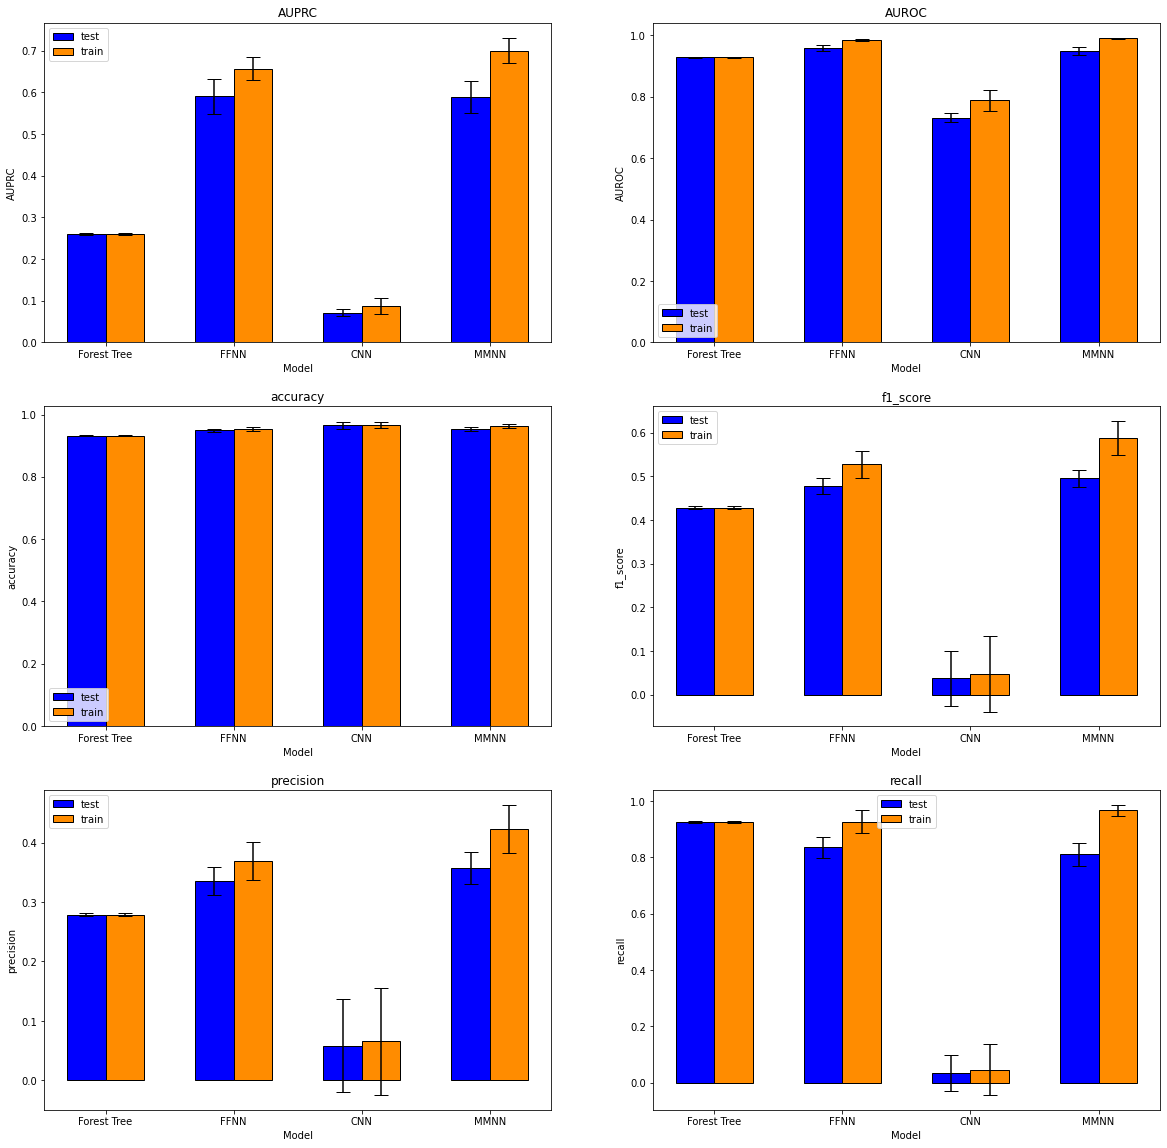

In [58]:
# Draw the plots of the performance for the enhancers.

# Plot the bar graphs.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
models_names=["Forest Tree","FFNN","CNN","MMNN"]
rows=metrics

for row,axis in zip(rows,axes.flatten()):
    axis.set_title(row)

    # Location of labels on the x axis.
    x_labels = np.arange(len(models_names))

    # Create the bars.
    axis.bar(x_labels - barWidth/2, mean_bar_enhancers[row]['test'], width = barWidth, color = 'blue', edgecolor = 'black', yerr=confidence_bar_enhancers[row]['test'], capsize=7, label='test')
    axis.bar(x_labels + barWidth/2, mean_bar_enhancers[row]['train'], width = barWidth, color = 'darkorange', edgecolor = 'black', yerr=confidence_bar_enhancers[row]['train'], capsize=7, label='train')

    # Lable the axis.
    axis.set_xlabel("Model")
    axis.set_xticks(x_labels)
    axis.set_xticklabels(models_names)
    axis.set_ylabel(row)

    axis.legend()
plt.show()  

In [59]:
# Report of the results:
for metric in metrics:
  for test_or_train in ['train','test']:
    for i in range(0,len(models_names)):
      print("medium value obtained from the {0} model for metric {1} on the {2} sets: {3}".format(models_names[i],metric,test_or_train,mean_bar_enhancers[metric][test_or_train][i]))


medium value obtained from the Forest Tree model for metric AUPRC on the train sets: 0.2597411523807313
medium value obtained from the FFNN model for metric AUPRC on the train sets: 0.6567339450120926
medium value obtained from the CNN model for metric AUPRC on the train sets: 0.08778197225183249
medium value obtained from the MMNN model for metric AUPRC on the train sets: 0.7003364711999893
medium value obtained from the Forest Tree model for metric AUPRC on the test sets: 0.2597411523807313
medium value obtained from the FFNN model for metric AUPRC on the test sets: 0.5908714979887009
medium value obtained from the CNN model for metric AUPRC on the test sets: 0.07134357606992126
medium value obtained from the MMNN model for metric AUPRC on the test sets: 0.5882480889558792
medium value obtained from the Forest Tree model for metric AUROC on the train sets: 0.9282937095738975
medium value obtained from the FFNN model for metric AUROC on the train sets: 0.9852474927902222
medium value 